In [1]:
import seaborn as sns
import pandas as pd

# Load dataset
df = sns.load_dataset("tips")

# Encode target label 'day'
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(df["day"])
labels = encoder.classes_

# Establish feature matrix X
X = df.drop(columns=["day"])

# One-hot encode remaining categorical features
X = pd.get_dummies(X)

# Show head of feature matrix
X.head()

,total_bill,tip,size,sex_Male,sex_Female,smoker_Yes,smoker_No,time_Lunch,time_Dinner
0,16.99,1.01,2,0,1,0,1,0,1
1,10.34,1.66,3,1,0,0,1,0,1
2,21.01,3.50,3,1,0,0,1,0,1
3,23.68,3.31,2,1,0,0,1,0,1
4,24.59,3.61,4,0,1,0,1,0,1


In [2]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Specify names and object of multiple classifier models
classifiers = {
    "Linear SVM": SVC(C=0.1, kernel="linear", probability=True),
    "RBF SVM": SVC(C=1, probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=6),
    "Neural Net": MLPClassifier(max_iter=10000),
    "Logistic Regression": LogisticRegression(C=1),
    "Nearest Neighbors": KNeighborsClassifier(n_neighbors=10),
    "Baseline": DummyClassifier(strategy="most_frequent"),
}

Note: It is not recommended to train multiple models at once like in this example, due to overall computational demand, the risk of losing the oversight on each model and the challenge it would mean for a proper hyperparameter search.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Split data set into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=24, stratify=y)

# Scale data set according to training set
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Collect multiple relevant information
scores = []
predicitions = []
clfs = []

# Loop through classifiers, train them and collect model information
for name in classifiers:

    # Select classifier
    clf = classifiers[name]

    # Train classifier
    clf.fit(X_train, y_train)
    clfs.append(clf)

    # Collect multiple model outputs
    scores.append(clf.score(X_test, y_test))
    predicitions.append(clf.predict(X_test))

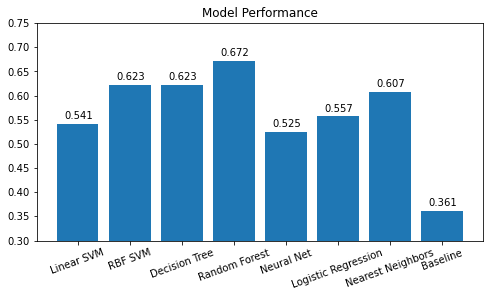

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Visualizing performance metric of each model
plt.figure(figsize=(8, 4))
plt.title("Model Performance")
plt.bar(classifiers.keys(), scores)
plt.ylim(0.30, 0.75)
plt.xticks(rotation=20)
for i, s in enumerate(np.array(scores).round(3)):
    plt.text(i - 0.25, s + 0.01, s)


On simple analysis Random forest looks to be best classifier but needs further analysis.

**Analysis of individual models**

From the figure above we can see that the baseline model (predict the most frequent training value) is at ~36% accuracy and that the Random Forest classifier reached ~66% accuracy. This is almost twice as much! But what exactly does that mean? What about the remaining ~34% that were misclassified? What is the model struggling with?

*Classification report*

In [6]:
from sklearn.metrics import classification_report

# Extract index of random forest classifier
rf_idx = list(classifiers.keys()).index("Random Forest")

# Plot classification report
report = classification_report(
    y_test, predicitions[rf_idx], zero_division=False, target_names=labels)
print(report)

              precision    recall  f1-score   support

         Fri       0.00      0.00      0.00         5
         Sat       0.54      0.86      0.67        22
         Sun       0.64      0.37      0.47        19
        Thur       1.00      1.00      1.00        15

    accuracy                           0.67        61
   macro avg       0.54      0.56      0.53        61
weighted avg       0.64      0.67      0.63        61



Interestingly, the Fri class, which only has 5 samples in the test set was never detected, while the Thur class was always correctly detected. And there seems to be some confusion between the Sat and Sun classes.

*Confusion Matrix*

ConfusionMatrixDisplay routine, which allows us to directly visualize the matrix in nice colors. We will once plot the confusion matrix for the random forest model in the standard (or count) version and once in the normalized version.



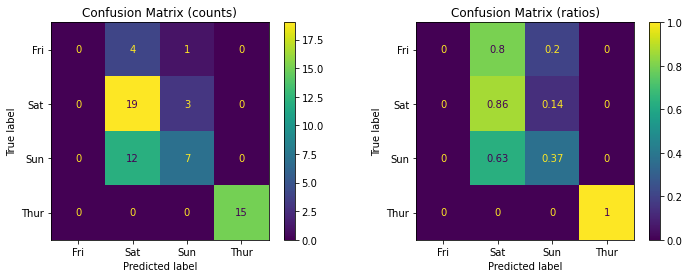

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_test, predicitions[rf_idx], display_labels=labels, ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_test, predicitions[rf_idx], normalize="true", display_labels=labels, ax=ax2)

plt.show()

 Using the normalize="true" parameter returns the percentage of correctly and misclassified samples per true class.

**Confusion matrices are great tools to see how well a classification model works, and more importantly to better understand how it fails. We would therefore recommend to plot them, together with the classification_report for every classification model you train.**

Alternatively plot with seaborn vs true:

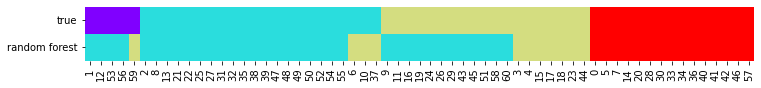

In [8]:
# Aggregate model predictions and tree values in a DataFrame
predicition_grid = pd.DataFrame(
    np.array(np.vstack((y_test, predicitions[rf_idx]))),
    index=["true", "random forest"])

# Sort the predictions per model (from top to bottom)
predicition_grid = predicition_grid.T.sort_values(
    by=predicition_grid.index.tolist()).T

# Plot predictions in a horizontal image
plt.figure(figsize=(12, 1))
sns.heatmap(predicition_grid, cmap="rainbow", cbar=False)
plt.show()

**Model Specific Information**

*Prediction probabilities*

While predict() gives the most likely class label for a given sample, predict_proba() provides the probability for how likely a given sample belongs to every target class.

In [9]:
# Collect prediction probabilities for
probabilities = [clf.predict_proba(X_test) for clf in clfs]

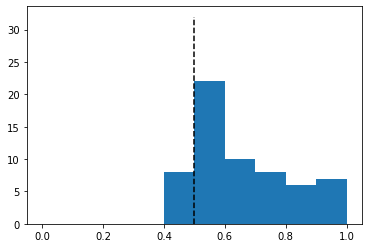

In [10]:
plt.hist(probabilities[rf_idx].max(axis=1), bins=np.arange(0, 1.01, 0.1))
plt.vlines(0.5, 0, 32, colors="k", linestyles="dashed")
plt.show()

We can now see how certain each model was at predicting. Dashed black line indicates middle between not certain and certain ie 50% and only 4 samples fell below this.

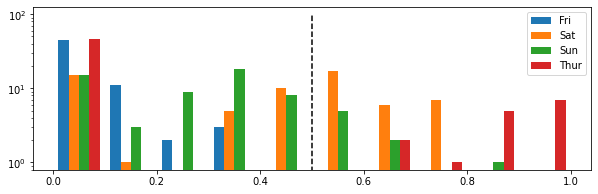

In [11]:
# Plot probabilities for a model
plt.figure(figsize=(10, 3))
plt.hist(probabilities[rf_idx], log=True)
plt.legend(labels)
plt.vlines(0.5, 0, 100, colors="k", linestyles="dashed")
plt.show()

As you can see, Thur (in red) are the only values that are exclusively below 0.1 or above this 0.5 value, while for Fri all values are below 0.5. As such, that doesn’t need to mean anything (remember that we have 4 target classes, i.e. complete uncertainty would be at 25%), but it is a good indication of how sure a model is with regards to its predictions.

To contrast this, let’s take a look at another model where these probabilities are a bit more separated.

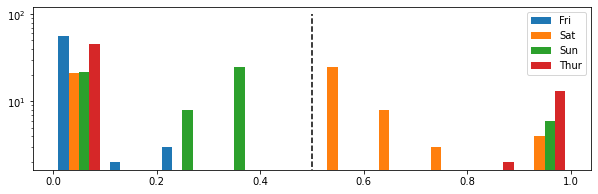

In [12]:
# Plot probabilities for a model
plt.figure(figsize=(10, 3))
plt.hist(probabilities[2], log=True)
plt.legend(labels)
plt.vlines(0.5, 0, 100, colors="k", linestyles="dashed")
plt.show()

We can see that this model (in this case the decision tree) is much more certain about its prediction. However, this doesn’t imply that it’s also more accurate.

An ideal situation would be a model that has high accuracy where almost all classes are predicted with either a probability around 100% or 0%. Samples that then fall in-between could be further investigated. However, such an ‘ideal’ model could potentially also be prone to overfitting.

*Feature Importance*

By looking at the feature importance or coefficients of such models, we can get some insights about which features help with the model predictions.

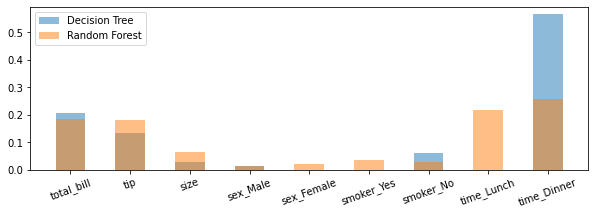

In [13]:
# Loop through the two models and plot their feature importance information
plt.figure(figsize=(10, 3))
for model in ["Decision Tree", "Random Forest"]:
    importances = clfs[list(classifiers.keys()).index(model)].feature_importances_
    plt.bar(X.columns, importances, alpha=0.5, label=model, width=0.5)
plt.xticks(rotation=20)
plt.legend()
plt.show()

As you can see, both models prefer similar features for their model predictions. However, while the decision tree ignores the time_Lunch feature and only looks at time_Dinner, the random forest model considers these two features equally.


**Comparing individual models**

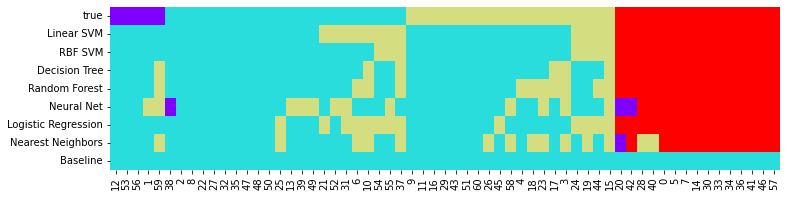

In [14]:
# Aggregate model predictions and tree values in a DataFrame
predicition_grid = pd.DataFrame(
    np.array(np.vstack((y_test, predicitions))),
    index=["true"] + list(classifiers.keys()))

# Sort the predictions per model (from top to bottom)
predicition_grid = predicition_grid.T.sort_values(by=predicition_grid.index.tolist()).T

# Plot predictions in a horizontal image
plt.figure(figsize=(12, 3))
sns.heatmap(predicition_grid, cmap="rainbow", cbar=False)
plt.show()

As you can see from this plot, none of the models is able to predict Fri (in violet), but the neural net and the nearest neighbors model misclassify other samples as Fri. Almost all models seem capable of correctly identifying Thur (in red). Furthermore, there are samples where all 7 models agreed in predicting Sat(in cyan) - in some cases correctly, in others incorrectly for Friand Sun.

Based on this figure you could now undertake additional investigations. What do the samples have in common where all 7 models agreed in predicting Sat (in)correctly? Why are the Linear SVM and Nearest Neighbors models almost identical in misclassifying Sat as Sun? And so forth.